# Problem of dogs and cats classification at Kaggle 

In [1]:
%matplotlib inline

In [37]:
path = "dogscats/"

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [4]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras.utils.data_utils import get_file
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image



Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)
/home/jan/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [124]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Initially, it is good to use a pretrained model which is trained on some standard data set and later on fine tuning it to achieve results. Here we have used vggnet example which won the image net challenge in the year 2014. After loading the pre trained weights we finetune the model for our data set particularly by popping out the last layer which classify the data into 1000 classes with a layer which classify data into 2 classes 

In [5]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))

pre processing function on image 

In [6]:
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

In [7]:
MODEL_PATH = 'http://www.platform.ai/models/'

Creating the vggnet model in keras below using sequential modelling

In [85]:
    

    
model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))


model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, activation='softmax'))

fname = 'vgg16.h5'
model.load_weights(get_file(fname, MODEL_PATH+fname, cache_subdir='models'))
 

    

/home/jan/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Following finetune function will let us change the classification classes from 1000 to 2 i.e. from default vggnet classification to our required classifiacation into cats and dogs 

In [76]:
def finetune(batches):
    
    model.pop()
    for layer in model.layers: layer.trainable=False 
    model.add(Dense(batches.nb_class, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])


Classes in Imagenet dataset 

In [89]:

fname = 'imagenet_class_index.json'
fpath = get_file(fname, MODEL_PATH+fname, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]


In [93]:
classes

[u'tench',
 u'goldfish',
 u'great_white_shark',
 u'tiger_shark',
 u'hammerhead',
 u'electric_ray',
 u'stingray',
 u'cock',
 u'hen',
 u'ostrich',
 u'brambling',
 u'goldfinch',
 u'house_finch',
 u'junco',
 u'indigo_bunting',
 u'robin',
 u'bulbul',
 u'jay',
 u'magpie',
 u'chickadee',
 u'water_ouzel',
 u'kite',
 u'bald_eagle',
 u'vulture',
 u'great_grey_owl',
 u'European_fire_salamander',
 u'common_newt',
 u'eft',
 u'spotted_salamander',
 u'axolotl',
 u'bullfrog',
 u'tree_frog',
 u'tailed_frog',
 u'loggerhead',
 u'leatherback_turtle',
 u'mud_turtle',
 u'terrapin',
 u'box_turtle',
 u'banded_gecko',
 u'common_iguana',
 u'American_chameleon',
 u'whiptail',
 u'agama',
 u'frilled_lizard',
 u'alligator_lizard',
 u'Gila_monster',
 u'green_lizard',
 u'African_chameleon',
 u'Komodo_dragon',
 u'African_crocodile',
 u'American_alligator',
 u'triceratops',
 u'thunder_snake',
 u'ringneck_snake',
 u'hognose_snake',
 u'green_snake',
 u'king_snake',
 u'garter_snake',
 u'water_snake',
 u'vine_snake',
 u'ni

Here as we can see I have used Keras, a flexible, easy to use deep learning library that sits on top of Theano(used here) or Tensorflow. Keras reads groups of images and labels in batches, using a fixed directory structure, where images from each category for training must be placed in a separate folder.
### DO PAY ATTENTION ON THE DIRECTORY STRUCTURE OTHERWISE IT WILL GIVE WRONG RESULTS OR AN ERROR!!

Creating batches so that you will not suffer from memory error 

In [41]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(path, target_size=(224,224),class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)


### Lets have a look at the dataset 

In [78]:
batches = get_batches(path+'train', batch_size=4)

Found 23000 images belonging to 2 classes.


Here, batches is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels. 

In [52]:
imgs,labels = next(batches)

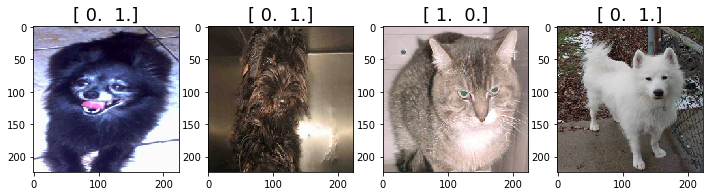

In [53]:
plots(imgs, titles=labels)

As you can see that all the cats are being given a vector of [1 0] and all the dogs have been given a vector of [0 1]

Making training batches and validation batches for fitting the cats and dogs dataset   

In [79]:
batches = get_batches(path+'train', batch_size=64)
val_batches = get_batches(path+'valid', batch_size=64)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [86]:
finetune(batches) #finetuning

#### FITTING THE MODEL

In [82]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [87]:
fit1(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 241s - loss: 0.1169 - acc: 0.9687 - val_loss: 0.0678 - val_acc: 0.9825

##### CREATING BATCHES FOR TEST DATA SET AND PREDICTING ON IT

In [102]:
batches, preds = test(path+'test', batch_size = 32)

Found 12500 images belonging to 1 classes.


In [103]:
def test(path, batch_size=8):
    test_batches = get_batches(path, shuffle=False, batch_size=batch_size, class_mode=None)
    return test_batches, model.predict_generator(test_batches, test_batches.nb_sample)


In [104]:
import pandas as pd

Preds gives us an array having two columns, the first column is the probaility of the image being a cat and second column is the probability of the image being a dog i.e if the preds is [1, 0], the image is likely to be a cat

In [120]:
preds[0,:]

array([  1.0000e+00,   1.4315e-09], dtype=float32)

In [123]:
filenames = batches.filenames
filenames[0]

'test1/4105.jpg'

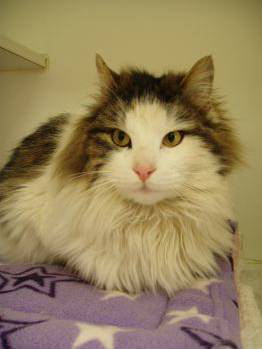

In [119]:
from PIL import Image
Image.open(path + 'test/' + filenames[0])

### WE CAN SEE CLEARLY THAT IT IS A CAT

#### creating the submission file to submit at kaggle

In [105]:
pred_dogs = preds[:,1]

In [106]:
pred_dogs

array([  1.4315e-09,   1.0000e+00,   9.9937e-01, ...,   6.1241e-10,   1.6165e-15,   9.9999e-01], dtype=float32)

In [107]:
final_pred = pd.DataFrame(batches.filenames,columns=['id'])

final_pred["label"] = pred_dogs

import re

In [110]:
final_pred.id = final_pred.id.apply(lambda x: re.sub(r"test1/",'',x))

final_pred.id = final_pred.id.apply(lambda x: re.sub(r".jpg",'',x))

final_pred.id = final_pred.id.astype('int')

final_pred = final_pred.sort_values(["id"])

final_pred.label = final_pred.label.apply(lambda x: round(x))

final_pred.to_csv("sub1.csv",index=False)